Advanced IPython breakout session
===
Created for the Berkeley Python Bootcamp August 2012 by Henrik Brink &lt;brink@berkeley.edu&gt;.

![XKCD Python comic](http://imgs.xkcd.com/comics/python.png)

Comic from <http://xkcd.com/353/>!

Introduction
---
In this breakout session we're going to try some of the more advanced features of IPython, mostly serving to optimize your code by using other languages (such as R and C/Cython) inline as well as seamless parallelization.

Throughout this we'll assume that you have started the IPython Notebook server with Pylab enabled for inline plotting:

Version 0.13 of IPython is highly recommended, as some of the features used in this session are newly introduced. Unfortunately, EPD currently ships with IPython 0.12, so you will have to either download the new version of IPython or make due with the 0.12 features (welcome to life on the edge!).

### The problem

We are going to define a simple problem that some of you might have run into during your work. Given some function that is complicated to calculate, you might want to use some sampling technique to trace out the function more efficiently than the brute force approach.

Let's first define some function that is supposed to be complicated. And pretty. Sorry if it's neither.

In [3]:
%pylab inline
import numpy
"""
A complicated function consisting of 3 2D gaussians.
"""
c_x1 = 0.5; c_y1 = 0.2; w_x1 = 0.15; w_y1 = 0.04
c_x2 = 0.7; c_y2 = 0.7; w_x2 = 0.05; w_y2 = 0.05
c_x3 = 0.3; c_y3 = 0.7; w_x3 = 0.05; w_y3 = 0.07
def gaussian(x, y):
    return \
    exp( -( ((c_x1 - x)/w_x1)**2. + ((c_y1 - y)/w_y1)**2. )/2 ) + \
    exp( -( ((c_x2 - x)/w_x2)**2. + ((c_y2 - y)/w_y2)**2. )/2 ) + \
    exp( -( ((c_x3 - x)/w_x3)**2. + ((c_y3 - y)/w_y3)**2. )/2 )

Populating the interactive namespace from numpy and matplotlib


Let's see how it looks (and pretend this is computationally intractable)

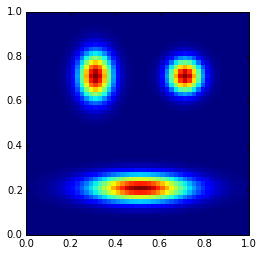

In [4]:
resolution = 50.
inds = indices((resolution,resolution))/resolution
imshow( gaussian(*inds).T, origin="lower", interpolation="nearest", extent=(0,1,0,1) );

Wait, who is that?

### Metropolis-Hastings sampler

Anyways, let's look at a way to sample arbitrary functions: The [Metropolis-Hastings algorithm](http://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm).

A very simple Metropolis-Hastings 2D random walker is defined below, along with a function for plotting the points returned by the walker:

In [5]:
"""
A very simple Metropolis-Hastings random walker in 2D
"""
def random_walker(func, n_steps=1000, start=[0,0], burn_in=100):
    points = []
    point = start
    for i in arange(n_steps):
        # Our jumping distribution is the [-0.1,0.1] Uniform distribution around the current point
        new_point = point + (rand(2)-0.5)/5.
        accept = func(*new_point) / func(*point)
        if accept >= 1 or rand() <= accept:
            point = new_point
            if i > burn_in: points.append(point)
    return asarray(points)

"""
A function to plot the points
"""
def plot_points(points):
    h2,_,_ = histogram2d(points[:,0], points[:,1], [resolution,resolution], range=[[0,1],[0,1]])
    imshow(h2.T, origin="lower", extent=(0,1,0,1), interpolation='nearest')

### Exercise 1

In the cell below, sample the function defined above using the Metropolis-Hastings sampler and plot the result.

In [ ]:
# Yes, you're up!

Try different walker parameters and see what happens.

What's wrong with that image?

### [Optional] Exercise 2

Time the random walker with n_steps=1e5 steps.

In [ ]:
# Time it

### Exercise 3

In the cell below, finish the code to start several random walkers at different locations and combine the output to show a more complete picture. We're creating 10 random starting positions, so you can go an order of magnitude down in sample size. Remember that this will take 10 times whatever you got in Exercise 2.

In [ ]:
# Fill out the missing pieces
starts = rand(10,2)
points = []
for start in starts:
    #points.append( ... )
plot_points( concatenate(points) )

Hopefully, you were able to sample a larger part of the function. But this comes at the cost of far more computing time...

Parallelization
----

At this point it would be very obvious to cut down on computation time by parallelizing the independent random walkers. But who wants to go through all the hastleof parallization?

Luckily, IPython makes it much easier to start parallel computing clusters and use those from IPython. If you're using version 0.13 of IPython, you can go to the Notebook Dashboard that appeared when you started the notebook server (you can get there again by hitting File -> Open above). Select the Clusters tab, insert the number of cores on your computer (usually 2 or 4) and hit Start.

I you're using 0.12, I would recommend you to update. If you're still using 0.12, you can start the cluster manually by issuing in the console:

The only thing you have to do now is enable parallel support in your running notebook:

In [ ]:
from IPython.parallel import Client
c = Client()

We now have all of the cores in the cluster available, and we can execute code on all of them by prefixing with a %px. We will use this to load the pylab interface on all engines:

In [ ]:
%px %pylab

You should see some startup output from all the engines in the cluster.

### Exercise 4

To run all the code in a notebook shell, you can start the whole cell with %%px. In fact, you are now going to use this to parallelize the code from above. It's almost easier than making the loop. 

The only thing that we need to do is define the functions that we use on all of the external cores. Simply head to the cells where the gaussian and the random_walker functions are defined, put %%px as the only thing on the first line and evaluate the cell again. This is a powerful feature of the notebook, that you can go back and forth between cells when your system changes, but it can also be dangerous. For example, if you close this notebook server and reopen, the %%px cells won't work until you've defined the cluster. Usually you want to do this at the beginning anyway.

When you come back here, fill out the cell below and enjoy the speedup:

In [ ]:
%%px
# ...

### Interacting with the engines

But how to get the results? We need to use the parallel Client object to get the variables defined on each machine. Below we do this and plot the result:

In [ ]:
plot_points(concatenate( c[:]["points"] ))

This hints to a pretty nice feature. With our cluster defined, we can get a single engine with c[id], and we can extract their variables using a standard Dict syntax. By using the --targets argument with %%px, we can control exactly what code is run on which engines. See more in the [IPython manual](http://ipython.org/ipython-doc/rel-0.13/parallel/magics.html).

It's out of the scope of this session, but the very cool thing about these engines is that they need not run on the local machine. In fact, they can run on any supercomputer in the world and still be used in exactly the same way from the Notebook or other IPython clients.

Other languages in the Notebook
----

But what if we're still not satisfied with the performance? In the IPython Notebook we can turn any cell into C code using the excellent Cython language and %cythonmagic feature. Note that running this requires Cython and a C compiler. You most likely have a C compiler, and Cython can easily be installed with easy_install (or pip):

We now load Cython functionality into the Notebook:

In [ ]:
%load_ext cythonmagic

### Exercise 5

Now we can transform any cell into a Cython cell by starting if off with %%cython. We will now use this to optimize our code even further, by reimplementing the 2D gaussian function in Cython code and hopefully gain some efficiency. Remember that this function is called at least twice pr. step by a random walker. Fill out the missing parts below. Hint: Cython is often just copy-pastable from regular Python. Hint 2: Use the imported pow instead of "**" for exponentiation.

In [ ]:
%%px
%%cython
cimport cython
from math import pow, exp
"""
A complicated function consisting of 3 2D gaussians, now in C with Cython.
"""
cdef double c_x1 = 0.5, c_y1 = 0.2, w_x1 = 0.15, w_y1 = 0.04
cdef double c_x2 = 0.7, c_y2 = 0.7, w_x2 = 0.05, w_y2 = 0.05
cdef double c_x3 = 0.3, c_y3 = 0.7, w_x3 = 0.05, w_y3 = 0.07
def gaussian_cython(x, y):
    return \
    #...


### [Optional] Exercise 6

Now run the random walker using the cython function as a replacement and time it. Any difference?

In [ ]:
# Your timing code here

### Putting everything together

We can now do something very cool: dispath the Cython'ized version of our code to our cluster of engines. Before this works, go back and load the cythonmagic and define the Cython function on all the cores (just place a %%px at the top, remember?).

### Exercise 7

Once again, fill out the missing parts below.

In [ ]:
%%px
# ...

In [ ]:
# Plot it

Fast eh?

### More magic

You can run many other languages in the Notebook, some of the must useful (depending on your background) might be the %%R magic (in the rmagic extension), the %%octave magic (in the octavemagic extension) and the built-in %%! magic for running things in the underlying command line shell.

### [Optional] Exercise 8

Load and use the R or Octave magics to plot the points from the random walker run, if you know how to use those.

In [ ]:
# Go for it!

### Taking your code to the cloud

You can go even further in the parallelization of your code by using a public cloud such as Amazon. PiCloud has made this very easy with Python, and you get a pretty substantial amount of free computing time every month.

Go to [PiCloud](https://www.picloud.com/) to read more, sign up and follow the instructions for installing their client package. After that, the steps below should just work! 

In [ ]:
import cloud

In [ ]:
def start_walker(start):
    return random_walker(gaussian, 1e5, start=start)

In [ ]:
starts = rand(10,2)
jids = cloud.map( start_walker, starts )

In [ ]:
plot_points(concatenate(cloud.result(jids)))